# Lab 10: Code your first Deep Reinforcement Learning Algorithm (Reinforce) with PyTorch


In this notebook, you'll code your first Deep Reinforcement Learning algorithm from scratch: Reinforce (also called Monte Carlo Policy Gradient).

Reinforce is a *Policy-based method*: a Deep Reinforcement Learning algorithm that tries **to optimize the policy directly without using an action-value function**.

More precisely, Reinforce is a *Policy-gradient method*, a subclass of *Policy-based methods* that aims **to optimize the policy directly by estimating the weights of the optimal policy using gradient ascent**.

To test its robustness, we're going to train it in 2 different simple environments:
- Cartpole-v1

⬇️ Here is an example of what **you will achieve at the end of this notebook.** ⬇️

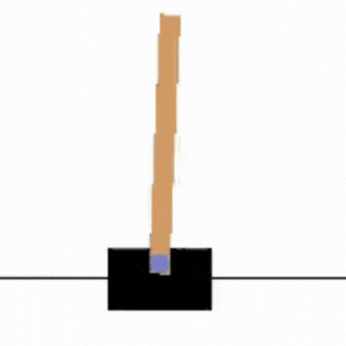


### 🎮 Environments:

- [CartPole-v1](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)

### 📚 RL-Library:

- Python
- PyTorch


## Objectives of this notebook 🏆
At the end of the notebook, you will:
- Be able to **code from scratch a Reinforce algorithm using PyTorch.**
- Be able to **test the robustness of your agent using simple environments.**

# Let's code Reinforce algorithm from scratch 🔥


To validate this hands-on for the certification process, you need to push your trained models to the Hub.

- Get a result of >= 350 for `Cartpole-v1`.

To find your result, go to the leaderboard and find your model, **the result = mean_reward - std of reward**. **If you don't see your model on the leaderboard, go at the bottom of the leaderboard page and click on the refresh button**.


## An advice 💡
It's better to run this colab in a copy on your Google Drive, so that **if it timeouts** you still have the saved notebook on your Google Drive and do not need to fill everything from scratch.

To do that you can either do `Ctrl + S` or `File > Save a copy in Google Drive.`

## Set the GPU 💪
- To **accelerate the agent's training, we'll use a GPU**. To do that, go to `Runtime > Change Runtime type`

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/gpu-step1.jpg" alt="GPU Step 1">

- `Hardware Accelerator > GPU`

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/gpu-step2.jpg" alt="GPU Step 2">

## Create a virtual display 🖥

During the notebook, we'll need to generate a replay video. To do so, with colab, **we need to have a virtual screen to be able to render the environment** (and thus record the frames).

Hence the following cell will install the librairies and create and run a virtual screen 🖥

In [ ]:
%%capture
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1

In [ ]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

## Install the dependencies 🔽
The first step is to install the dependencies. We’ll install multiple ones:

- `gym`
- `gym-games`: Extra gym environments made with PyGame.
- `huggingface_hub`: 🤗 works as a central place where anyone can share and explore models and datasets. It has versioning, metrics, visualizations, and other features that will allow you to easily collaborate with others.

You may be wondering why we install gym and not gymnasium, a more recent version of gym? **Because the gym-games we are using are not updated yet with gymnasium**.

The differences you'll encounter here:
- In `gym` we don't have `terminated` and `truncated` but only `done`.
- In `gym` using `env.step()` returns `state, reward, done, info`

You can learn more about the differences between Gym and Gymnasium here 👉 https://gymnasium.farama.org/content/migration-guide/


You can see here all the Reinforce models available 👉 https://huggingface.co/models?other=reinforce

And you can find all the Deep Reinforcement Learning models here 👉 https://huggingface.co/models?pipeline_tag=reinforcement-learning


In [ ]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit4/requirements-unit4.txt
!pip install --upgrade numpy

## Import the packages 📦
In addition to import the installed libraries, we also import:

- `imageio`: A library that will help us to generate a replay video



In [ ]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym
import gym_pygame

# Hugging Face Hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.
import imageio

## Check if we have a GPU

- Let's check if we have a GPU
- If it's the case you should see `device:cuda0`

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

We're now ready to implement our Reinforce algorithm 🔥

# First agent: Playing CartPole-v1 🤖

## Create the CartPole environment and understand how it works
### [The environment 🎮](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)


### Why do we use a simple environment like CartPole-v1?
As explained in [Reinforcement Learning Tips and Tricks](https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html), when you implement your agent from scratch you need **to be sure that it works correctly and find bugs with easy environments before going deeper**. Since finding bugs will be much easier in simple environments.


> Try to have some “sign of life” on toy problems


> Validate the implementation by making it run on harder and harder envs (you can compare results against the RL zoo). You usually need to run hyperparameter optimization for that step.
___
### The CartPole-v1 environment

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.



So, we start with CartPole-v1. The goal is to push the cart left or right **so that the pole stays in the equilibrium.**

The episode ends if:
- The pole Angle is greater than ±12°
- Cart Position is greater than ±2.4
- Episode length is greater than 500

We get a reward 💰 of +1 every timestep the Pole stays in the equilibrium.

In [ ]:
env_id = "CartPole-v1"
# Create the env
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

## Let's build the Reinforce Architecture
This implementation is based on two implementations:
- [PyTorch official Reinforcement Learning example](https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py)
- [Udacity Reinforce](https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb)
- [Improvement of the integration by Chris1nexus](https://github.com/huggingface/deep-rl-class/pull/95)

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/reinforce.png" alt="Reinforce"/>

So we want:
- Two fully connected layers (fc1 and fc2).
- Using ReLU as activation function of fc1
- Using Softmax to output a probability distribution over actions

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        # Create two fully connected layers
        # YOUR CODE HERE

    def forward(self, x):
        # Define the forward pass
        # YOUR CODE HERE

        # x goes to fc1 then we apply ReLU activation function

        # fc1 outputs goes to fc2

        # We return the softmax

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

**Question 1:**

In `def act(self, state)` function, we have `action = m.sample()`, why do we use sample rather than `action = np.argmax(m)`?

**Answer:**

YOUR ANSWER HERE


### Let's build the Reinforce Training Algorithm
This is the Reinforce algorithm pseudocode:

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/pg_pseudocode.png" alt="Policy gradient pseudocode"/>
  

- When we calculate the return Gt (line 6) we see that we calculate the sum of discounted rewards **starting at timestep t**.

- Why? Because our policy should only **reinforce actions on the basis of the consequences**: so rewards obtained before taking an action are useless (since they were not because of the action), **only the ones that come after the action matters**.

- Before coding this you should read this section [don't let the past distract you](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#don-t-let-the-past-distract-you) that explains why we use reward-to-go policy gradient.

But overall the idea is to **compute the return at each timestep efficiently**.

In [ ]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []

    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        # YOUR CODE HERE
        # TODO: reset the environment
        state =

        # Line 4 of pseudocode
        for t in range(max_t):
            # YOUR CODE HERE
            action, log_prob =  # TODO get the action

            saved_log_probs.append(log_prob)
            # YOUR CODE HERE
            state, reward, done, _ =  # TODO: take an env step
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)

        # Compute the discounted returns at each timestep,
        # as the sum of the gamma-discounted return at time t (G_t) + the reward at time t

        # In O(N) time, where N is the number of time steps
        # (this definition of the discounted return G_t follows the definition of this quantity
        # shown at page 44 of Sutton&Barto 2017 2nd draft)
        # G_t = r_(t+1) + r_(t+2) + ...

        # Given this formulation, the returns at each timestep t can be computed
        # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order
        # to avoid computing them multiple times)

        # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
        # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...


        ## Given the above, we calculate the returns at timestep t as:
        #               gamma[t] * return[t] + reward[t]
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed
        ## if we were to do it from first to last.

        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            if len(returns)>0:
                disc_return_t = returns[0]
            else:
                disc_return_t = 0
            # we calculate the returns at timestep t as: gamma[t] * return[t] + reward[t]
            returns.appendleft(gamma*disc_return_t + rewards[t])

        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()

        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

**Question 2:**

What does `range(n_steps)[::-1]` do?

**Answer:**

YOUR ANSWER HERE

##  Train it
- We're now ready to train our agent.
- But first, we define a variable containing all the training hyperparameters.
- You can change the training parameters (and should 😉)

In [ ]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 400,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [ ]:
# Create policy and place it to the device
cartpole_policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

In [ ]:
!pip install --upgrade numpy

scores = reinforce(cartpole_policy,
                   cartpole_optimizer,
                   cartpole_hyperparameters["n_training_episodes"],
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"],
                   100)

## Define evaluation method 📝
- Here we define the evaluation method that we're going to use to test our Reinforce agent.

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

## Evaluate our agent 📈

In [ ]:
!pip install --upgrade numpy
evaluate_agent(eval_env,
               cartpole_hyperparameters["max_t"],
               cartpole_hyperparameters["n_evaluation_episodes"],
               cartpole_policy)

In [ ]:
def record_video(env, policy, out_directory, fps=30):
  """
  Generate a replay video of the agent
  :param env
  :param Qtable: Qtable of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  done = False
  state = env.reset()
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action, _ = policy.act(state)
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)

  # Create the full path for the output video file
  video_path = f"{out_directory}/cartpole_video.mp4"

  imageio.mimsave(video_path, [np.array(img) for i, img in enumerate(images)], fps=fps)

record_video(eval_env,cartpole_policy,"/content/")

Now that we try the robustness of our implementation, let's download the videos to see if it works fine!
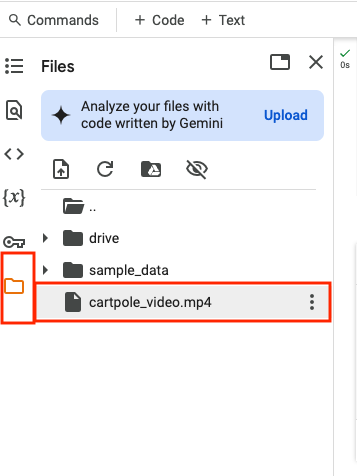




## Some additional challenges 🏆
The best way to learn **is to try things on your own**! As you saw, the current agent is not doing great. As a first suggestion, you can train for more steps. But also trying to find better parameters.

Here are some ideas to achieve so:
* Train more steps
* Try different hyperparameters by looking at what your classmates have done 👉 https://huggingface.co/models?other=reinforce
* **Push your new trained model** on the Hub 🔥
* **Improving the implementation for more complex environments** (for instance, what about changing the network to a Convolutional Neural Network to handle
frames as observation)?

________________________________________________________________________

**Congrats on finishing this unit**! There was a lot of information.
And congrats on finishing the tutorial. You've just coded your first Deep Reinforcement Learning agent from scratch using PyTorch 🥳.

### Keep Learning, stay awesome 🤗

